In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 设置 Matplotlib 支持中文显示
plt.rcParams['font.sans-serif'] = ['SimSong']  # 'SimSong' 宋体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号'-'显示为方块的问题

# 加载上一步处理好的数据
df = pd.read_parquet('../Data/cleaned_full_data.parquet')
print("数据加载成功！")
display(df.info())

数据加载成功！
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8981 entries, 0 to 8980
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   面积(㎡)        8981 non-null   float64
 1   总价(万)        4800 non-null   float64
 2   单价(元/㎡)      4800 non-null   float64
 3   地区           8981 non-null   object 
 4   类型           8981 non-null   object 
 5   租金(元/月)      4181 non-null   float64
 6   租金单价(元/㎡/月)  4181 non-null   float64
dtypes: float64(5), object(2)
memory usage: 491.3+ KB


None

1. 对二手房和租房的单价数据进行描述性统计

In [14]:
# 二手房单价描述
df_esf = df[df['类型'] == 'esf']
esf_desc = df_esf.groupby('地区')['单价(元/㎡)'].describe()

print("--- 各地区二手房单价(元/㎡)描述性统计 ---")
display(esf_desc)

# 租房单价描述
df_zu = df[df['类型'] == 'zu']
zu_desc = df_zu.groupby('地区')['租金单价(元/㎡/月)'].describe()

print("\n--- 各地区租房单价（元/㎡/月）描述性统计 ---")
display(zu_desc)

--- 各地区二手房单价(元/㎡)描述性统计 ---


,count,mean,std,min,25%,50%,75%,max
地区,,,,,,,,
Balitai,1200.0,29455.316667,13430.439144,11422.0,21718.00,26074.0,31578.00,127575.0
Quanyechang,1200.0,51619.800000,19151.286549,7422.0,39015.25,47601.0,58500.00,170731.0
Wuqing,1200.0,12492.114167,4728.726734,3633.0,9349.75,11639.5,14499.75,53715.0
Zhongxin,1200.0,14241.283333,5052.387193,6481.0,10467.75,13764.0,18513.75,27895.0



--- 各地区租房单价（元/㎡/月）描述性统计 ---


,count,mean,std,min,25%,50%,75%,max
地区,,,,,,,,
Balitai,614.0,46.243432,16.486070,9.016393,36.082474,43.159537,52.500000,126.050420
Quanyechang,1167.0,67.988298,32.946574,23.214286,53.956835,62.500000,73.790008,758.620690
Wuqing,1200.0,16.232599,7.602423,3.012048,10.817098,15.868006,20.661544,61.111111
Zhongxin,1200.0,24.947102,4.931604,14.942529,22.320261,23.946903,26.610532,52.173913


In [17]:
# 定义一个函数，使用IQR（四分位距）方法来找出离群值
def find_outliers_iqr(data_series):
    Q1 = data_series.quantile(0.25)
    Q3 = data_series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data_series[(data_series < lower_bound) | (data_series > upper_bound)]
    return outliers

# --- 找出二手房单价的离群值 ---
print("--- 二手房单价离群值 ---")
sales_outliers = df_esf.groupby('地区')['单价(元/㎡)'].apply(find_outliers_iqr)
display(sales_outliers)

# --- 找出租房单价的离群值 ---
print("\n--- 租房单价离群值 ---")
rent_outliers = df_zu.groupby('地区')['租金单价(元/㎡/月)'].apply(find_outliers_iqr)
display(rent_outliers)

--- 二手房单价离群值 ---


地区           
Balitai  2445    107831.0
         2464     51299.0
         2492     56793.0
         2503     49504.0
         2509     55056.0
                   ...   
Wuqing   2317     23416.0
         2325     25715.0
         2349     25715.0
         2359     23416.0
         2375     22775.0
Name: 单价(元/㎡), Length: 226, dtype: float64


--- 租房单价离群值 ---


地区            
Balitai   7170     78.947368
          7203    103.448276
          7250     80.000000
          7265    125.000000
          7271     92.307692
                     ...    
Zhongxin  8812     52.173913
          8867     14.942529
          8872     52.173913
          8927     14.942529
          8932     52.173913
Name: 租金单价(元/㎡/月), Length: 172, dtype: float64

    我们接下来通过箱型图来直观可视化离群值

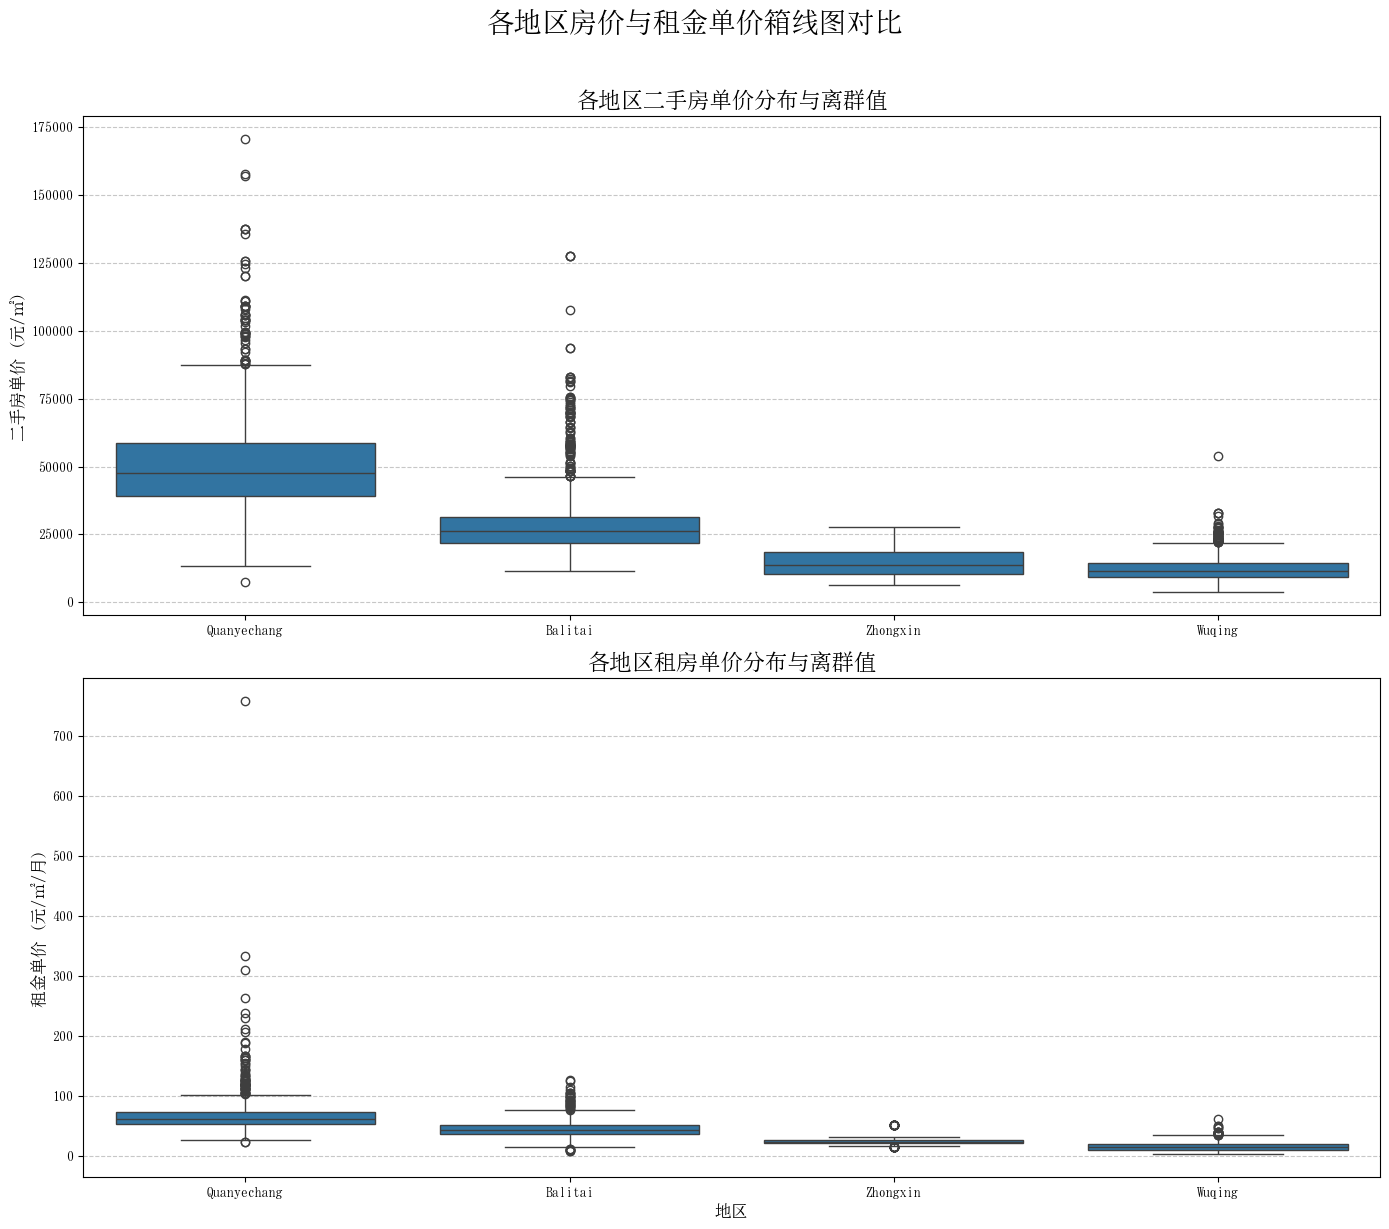

In [ ]:
# 1. 确定一个统一的 x 轴顺序
order = df_esf.groupby('地区')['单价(元/㎡)'].median().sort_values(ascending=False).index

# 2. 创建一个 2x1 的子图画布
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# 3. 在第一个子图 (axes[0]) 上绘制二手房单价的箱线图
sns.boxplot(data=df_esf, x='地区', y='单价(元/㎡)', ax=axes[0], order=order)
axes[0].set_title('各地区二手房单价分布与离群值', fontsize=16)
axes[0].set_xlabel('')
axes[0].set_ylabel('二手房单价 (元/㎡)', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# 4. 在第二个子图 (axes[1]) 上绘制租房单价的箱线图
sns.boxplot(data=df_zu, x='地区', y='租金单价(元/㎡/月)', ax=axes[1], order=order)
axes[1].set_title('各地区租房单价分布与离群值', fontsize=16)
axes[1].set_xlabel('地区', fontsize=12) # 只在最下方的子图显示x轴标签
axes[1].set_ylabel('租金单价 (元/㎡/月)', fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# 5. 添加一个总标题
fig.suptitle('各地区房价与租金单价箱线图对比', fontsize=20, y=1.02)

# 6. 自动调整子图布局，防止重叠
plt.tight_layout()

# 7. 显示图表
plt.show()

--- 各地区核心投资指标 ---


,二手房单价中位数(元/㎡),月租金单价中位数(元/㎡/月),租售比
地区,,,
Zhongxin,13764.0,23.946903,574.771619
Balitai,26074.0,43.159537,604.130676
Wuqing,11639.5,15.868006,733.520027
Quanyechang,47601.0,62.500000,761.616000


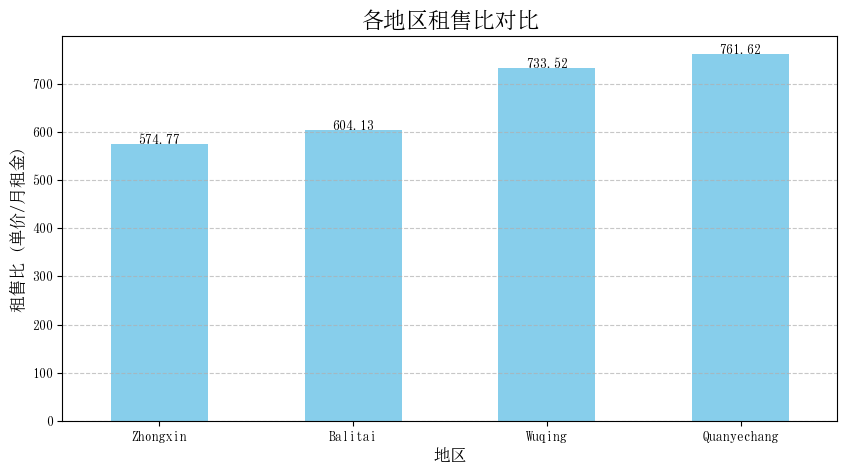

In [ ]:
# 按地区分组，分别计算单价的中位数和租金的中位数
median_prices = df[df['类型'] == 'esf'].groupby('地区')['单价(元/㎡)'].median()
median_rents = df[df['类型'] == 'zu'].groupby('地区')['租金单价(元/㎡/月)'].median()

# 合并成一个新的DataFrame
ratio_df = pd.DataFrame({
    '二手房单价中位数(元/㎡)': median_prices,
    '月租金单价中位数(元/㎡/月)': median_rents
})



# 计算租售比
ratio_df['租售比'] = ratio_df['二手房单价中位数(元/㎡)'] / ratio_df['月租金单价中位数(元/㎡/月)']
display(ratio_df.sort_values('租售比', ascending=True))

# --- 可视化租售比 ---
plt.figure(figsize=(10, 5))
ax = ratio_df['租售比'].sort_values().plot(kind='bar', color='skyblue')
ax.set_title('各地区租售比对比', fontsize=16)
ax.set_ylabel('租售比 (单价/月租金)', fontsize=12)
ax.set_xlabel('地区', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# 在每个柱子上方添加数值标签
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.,
            height + 0.05,
            f'{height:.2f}',
            ha='center'
        )

# 定义保存的文件夹和文件名
figure_dir = '../figure_results'
file_name = 'FigureA.png'
output_path = os.path.join(figure_dir, file_name)

# 确保文件夹存在，如果不存在则创建它
os.makedirs(figure_dir, exist_ok=True)

# 保存图表
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()